In [201]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit.circuit import ParameterVector
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Statevector

from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_aer.primitives import Sampler
from qiskit_finance.applications.estimation import EuropeanCallPricing
from qiskit_finance.circuit.library import NormalDistribution

In [202]:
# upper + lower bounds 
bounds = np.array([0.0, 7.0])
# setting qubit #
num_qubits = 3

g_params = [0.367845, 0.128729, 0.908456, 0.621987, 0.485623, 0.793521]

# generator circuit initial state
init_dist = NormalDistribution(num_qubits, mu=1.0, sigma=1.0, bounds=bounds)

var_form = TwoLocal(num_qubits, "ry", "cz", entanglement="circular", reps=1)

#saving list of parameters
theta = var_form.ordered_parameters

g_circuit = init_dist.compose(var_form)

In [203]:
# strike price 
strike_price = 3

# payoff function scaling
c_approx = 0.5

In [204]:
# trained probability distribution
values = [
    bounds[0] + (bounds[1] - bounds[0]) * x / (2**num_qubits - 1) for x in range(2**num_qubits)
]
uncertainty_model = g_circuit.assign_parameters(dict(zip(theta, g_params)))
amplitudes = Statevector.from_instruction(uncertainty_model).data

x = np.array(values)
y = np.abs(amplitudes) ** 2

# sample from target probability distribution
N = 100000
log_normal = np.random.lognormal(mean=1, sigma=1, size=N)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= 7]
log_normal_samples = []
for i in range(8):
    log_normal_samples += [np.sum(log_normal == i)]
log_normal_samples = np.array(log_normal_samples / sum(log_normal_samples))

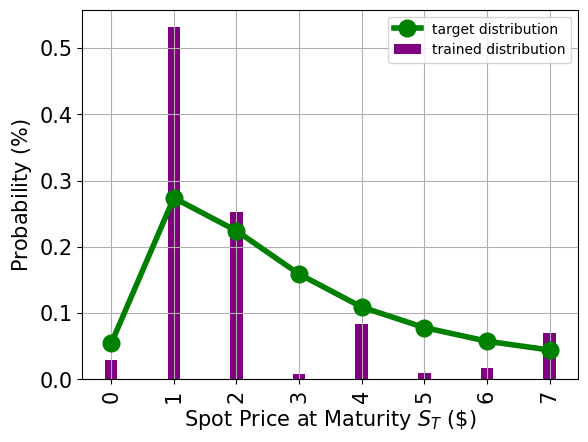

In [211]:
plt.bar(x, y, width=0.2, label="trained distribution", color="purple")
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.plot( log_normal_samples, "-o", color="green", label="target distribution", linewidth=4, markersize=12)
plt.legend(loc="best")
plt.show()

Analytically calculated expected payoff w.r.t. the target distribution:  1.0629
Analytically calculated expected payoff w.r.t. the trained distribution: 0.6165


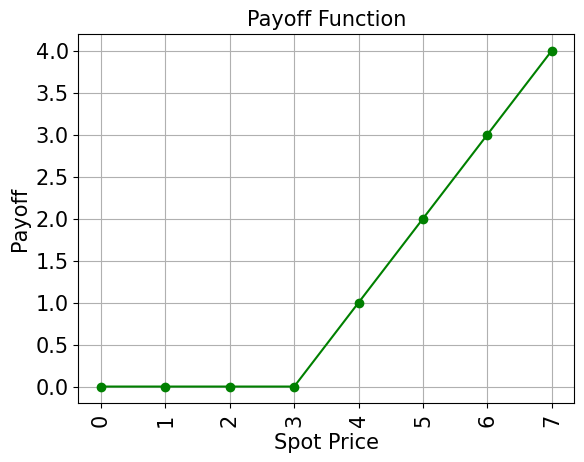

In [214]:
payoff = np.array([0, 0, 0, 1, 2, 3, 4, 5])
ep = np.dot(log_normal_samples, payoff)
print("Analytically calculated expected payoff w.r.t. the target distribution:  %.4f" % ep)
ep_trained = np.dot(y, payoff)
print("Analytically calculated expected payoff w.r.t. the trained distribution: %.4f" % ep_trained)

x = np.array(values)
y_strike = np.maximum(0, x - strike_price)
plt.plot(x, y_strike, "go-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [207]:
european_call_pricing = EuropeanCallPricing(num_qubits, strike_price=strike_price, rescaling_factor=c_approx, bounds=bounds, uncertainty_model=uncertainty_model)

# target precision and confidence level
epsilon = 0.01
alpha = 0.05

In [208]:
problem = european_call_pricing.to_estimation_problem()
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100}))

result = ae.estimate(problem)

In [209]:
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % ep_trained)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.6165
Estimated value:    	-0.5463
Confidence interval:	[-0.5465, -0.5462]
